In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [2]:
dataset_path = 'data/data_speech_commands_v0.02'

In [3]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['zero', 'four', 'three', 'right', 'cat', 'tree', 'happy', 'one', 'wow', 'up', 'down', 'house', 'marvin', 'two', 'yes', 'nine', 'bella', 'bird', 'learn', 'sheila', 'dog', 'bed', 'eight', 'on', 'stop', 'left', 'forward', 'six', 'off', 'visual', 'five', 'backward', 'go', 'no', 'seven', 'follow']


In [4]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

4052
3728
3727
3778
2031
1759
2054
3890
2123
3723
3917
2113
2100
3880
4044
3934
521
2064
1575
2022
2128
2014
3787
3845
3872
3801
1557
3860
3745
1592
4052
1664
3880
3941
3998
1579
Total samples: 106350


In [5]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [6]:
max_samples_per_word = 530

In [7]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    files = listdir(join(dataset_path, target))[:max_samples_per_word]
    print(f"Adding {len(files)} samples")
    filenames.append(files)
    y.append(np.ones(len(filenames[index])) * index)

data/data_speech_commands_v0.02/zero
Adding 530 samples
data/data_speech_commands_v0.02/four
Adding 530 samples
data/data_speech_commands_v0.02/three
Adding 530 samples
data/data_speech_commands_v0.02/right
Adding 530 samples
data/data_speech_commands_v0.02/cat
Adding 530 samples
data/data_speech_commands_v0.02/tree
Adding 530 samples
data/data_speech_commands_v0.02/happy
Adding 530 samples
data/data_speech_commands_v0.02/one
Adding 530 samples
data/data_speech_commands_v0.02/wow
Adding 530 samples
data/data_speech_commands_v0.02/up
Adding 530 samples
data/data_speech_commands_v0.02/down
Adding 530 samples
data/data_speech_commands_v0.02/house
Adding 530 samples
data/data_speech_commands_v0.02/marvin
Adding 530 samples
data/data_speech_commands_v0.02/two
Adding 530 samples
data/data_speech_commands_v0.02/yes
Adding 530 samples
data/data_speech_commands_v0.02/nine
Adding 530 samples
data/data_speech_commands_v0.02/bella
Adding 521 samples
data/data_speech_commands_v0.02/bird
Adding 530 

In [8]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [9]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [10]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

19071
19071


In [11]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [12]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [13]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [14]:
def signal_to_mfcc(signal, fs):
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [15]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    return signal_to_mfcc(signal, fs)

In [16]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1

Dropped: 4 (16, 15)
Dropped: 20 (16, 7)
Dropped: 26 (16, 13)
Dropped: 42 (16, 8)
Dropped: 43 (16, 15)
Dropped: 69 (16, 11)
Dropped: 70 (16, 13)
Dropped: 75 (16, 9)
Dropped: 77 (16, 13)
Dropped: 129 (16, 13)
Dropped: 140 (16, 12)
Dropped: 182 (16, 13)
Dropped: 199 (16, 12)
Dropped: 204 (16, 11)
Dropped: 227 (16, 15)
Dropped: 228 (16, 13)
Dropped: 234 (16, 14)
Dropped: 240 (16, 14)
Dropped: 244 (16, 14)
Dropped: 245 (16, 13)
Dropped: 254 (16, 14)
Dropped: 255 (16, 12)
Dropped: 267 (16, 12)
Dropped: 281 (16, 7)
Dropped: 283 (16, 12)
Dropped: 285 (16, 9)
Dropped: 291 (16, 13)
Dropped: 294 (16, 10)
Dropped: 300 (16, 13)
Dropped: 318 (16, 11)
Dropped: 321 (16, 14)
Dropped: 338 (16, 11)
Dropped: 385 (16, 8)
Dropped: 397 (16, 15)
Dropped: 398 (16, 13)
Dropped: 401 (16, 11)
Dropped: 406 (16, 12)
Dropped: 409 (16, 5)
Dropped: 428 (16, 6)
Dropped: 440 (16, 12)
Dropped: 468 (16, 13)
Dropped: 470 (16, 12)
Dropped: 474 (16, 15)
Dropped: 480 (16, 14)


In [17]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.088


MFCCs: [[-5.67869770e+01 -5.68507154e+01 -5.63342743e+01 -5.34953822e+01
  -4.17760449e+01 -3.28848193e+01 -2.39122794e+01 -1.50279458e+01
  -1.22625340e+01 -1.28144553e+01 -1.81822530e+01 -2.68303888e+01
  -3.52942163e+01 -4.50993700e+01 -5.22734734e+01 -5.53143019e+01]
 [ 5.60390785e+00  5.65236262e+00  5.55295618e+00  2.57177866e+00
  -5.48634323e+00 -1.02612056e+01 -8.45804532e+00 -3.33457152e+00
   5.10263078e-01  1.43668009e+00  2.57638703e+00  4.95335659e+00
   6.26184780e+00  6.49910936e+00  5.81482842e+00  6.11572750e+00]
 [ 2.54378536e+00  2.54537754e+00  2.75597978e+00  5.04822498e+00
   7.45947799e+00  7.46974230e+00  5.70981223e+00  1.69316821e+00
   4.82615168e-02  1.43956132e+00  5.00666628e+00  8.63266484e+00
   8.66391560e+00  6.50690730e+00  4.91864212e+00  3.22021934e+00]
 [ 2.29632887e+00  2.19140265e+00  2.47606909e+00  1.35454871e+00
  -1.83071057e-01  8.65089362e-01  7.63861504e-01  3.98512233e-01
   1.51567204e+00  1.92539298e+00  1.09297251e+00 -9.10266921e-01


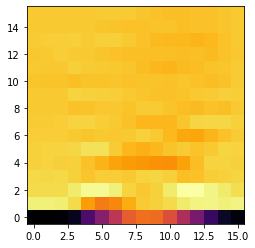

In [18]:
# TEST: Test shorter MFCC
# !pip install playsound
from playsound import playsound

idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
playsound(path)

In [19]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [20]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 4 (16, 15)
Dropped: 20 (16, 7)
Dropped: 26 (16, 13)
Dropped: 42 (16, 8)
Dropped: 43 (16, 15)
Dropped: 69 (16, 11)
Dropped: 70 (16, 13)
Dropped: 75 (16, 9)
Dropped: 77 (16, 13)
Dropped: 129 (16, 13)
Dropped: 140 (16, 12)
Dropped: 182 (16, 13)
Dropped: 199 (16, 12)
Dropped: 204 (16, 11)
Dropped: 227 (16, 15)
Dropped: 228 (16, 13)
Dropped: 234 (16, 14)
Dropped: 240 (16, 14)
Dropped: 244 (16, 14)
Dropped: 245 (16, 13)
Dropped: 254 (16, 14)
Dropped: 255 (16, 12)
Dropped: 267 (16, 12)
Dropped: 281 (16, 7)
Dropped: 283 (16, 12)
Dropped: 285 (16, 9)
Dropped: 291 (16, 13)
Dropped: 294 (16, 10)
Dropped: 300 (16, 13)
Dropped: 318 (16, 11)
Dropped: 321 (16, 14)
Dropped: 338 (16, 11)
Dropped: 385 (16, 8)
Dropped: 397 (16, 15)
Dropped: 398 (16, 13)
Dropped: 401 (16, 11)
Dropped: 406 (16, 12)
Dropped: 409 (16, 5)
Dropped: 428 (16, 6)
Dropped: 440 (16, 12)
Dropped: 468 (16, 13)
Dropped: 470 (16, 12)
Dropped: 474 (16, 15)
Dropped: 480 (16, 14)
Dropped: 515 (16, 11)
Dropped: 517 (16, 13)
Droppe

Dropped: 3999 (16, 14)
Dropped: 4004 (16, 15)
Dropped: 4011 (16, 12)
Dropped: 4034 (16, 7)
Dropped: 4039 (16, 13)
Dropped: 4055 (16, 11)
Dropped: 4061 (16, 15)
Dropped: 4075 (16, 13)
Dropped: 4105 (16, 5)
Dropped: 4109 (16, 14)
Dropped: 4110 (16, 6)
Dropped: 4117 (16, 13)
Dropped: 4118 (16, 15)
Dropped: 4132 (16, 12)
Dropped: 4133 (16, 12)
Dropped: 4135 (16, 15)
Dropped: 4152 (16, 13)
Dropped: 4159 (16, 10)
Dropped: 4161 (16, 9)
Dropped: 4162 (16, 14)
Dropped: 4163 (16, 22)
Dropped: 4169 (16, 15)
Dropped: 4177 (16, 12)
Dropped: 4213 (16, 14)
Dropped: 4221 (16, 11)
Dropped: 4232 (16, 10)
Dropped: 4235 (16, 15)
Dropped: 4241 (16, 10)
Dropped: 4246 (16, 10)
Dropped: 4282 (16, 15)
Dropped: 4284 (16, 12)
Dropped: 4293 (16, 13)
Dropped: 4295 (16, 14)
Dropped: 4299 (16, 12)
Dropped: 4310 (16, 7)
Dropped: 4316 (16, 15)
Dropped: 4321 (16, 12)
Dropped: 4322 (16, 14)
Dropped: 4324 (16, 15)
Dropped: 4332 (16, 7)
Dropped: 4342 (16, 11)
Dropped: 4355 (16, 13)
Dropped: 4360 (16, 8)
Dropped: 4365 (16,

Dropped: 7929 (16, 15)
Dropped: 7936 (16, 12)
Dropped: 7957 (16, 13)
Dropped: 7964 (16, 13)
Dropped: 7965 (16, 9)
Dropped: 7976 (16, 11)
Dropped: 7979 (16, 5)
Dropped: 7987 (16, 12)
Dropped: 7991 (16, 14)
Dropped: 8003 (16, 11)
Dropped: 8043 (16, 15)
Dropped: 8101 (16, 15)
Dropped: 8128 (16, 6)
Dropped: 8130 (16, 12)
Dropped: 8145 (16, 10)
Dropped: 8162 (16, 15)
Dropped: 8165 (16, 14)
Dropped: 8176 (16, 11)
Dropped: 8194 (16, 14)
Dropped: 8222 (16, 14)
Dropped: 8255 (16, 13)
Dropped: 8277 (16, 13)
Dropped: 8283 (16, 11)
Dropped: 8293 (16, 22)
Dropped: 8313 (16, 6)
Dropped: 8316 (16, 13)
Dropped: 8326 (16, 11)
Dropped: 8334 (16, 11)
Dropped: 8344 (16, 13)
Dropped: 8365 (16, 13)
Dropped: 8370 (16, 14)
Dropped: 8373 (16, 12)
Dropped: 8377 (16, 11)
Dropped: 8418 (16, 14)
Dropped: 8431 (16, 13)
Dropped: 8443 (16, 15)
Dropped: 8445 (16, 8)
Dropped: 8450 (16, 8)
Dropped: 8474 (16, 15)
Dropped: 8480 (16, 11)
Dropped: 8486 (16, 7)
Dropped: 8499 (16, 13)
Dropped: 8500 (16, 15)
Dropped: 8509 (16,

Dropped: 11846 (16, 15)
Dropped: 11848 (16, 6)
Dropped: 11852 (16, 10)
Dropped: 11855 (16, 9)
Dropped: 11876 (16, 9)
Dropped: 11893 (16, 15)
Dropped: 11896 (16, 7)
Dropped: 11899 (16, 13)
Dropped: 11918 (16, 13)
Dropped: 11936 (16, 13)
Dropped: 11939 (16, 13)
Dropped: 11945 (16, 15)
Dropped: 11951 (16, 13)
Dropped: 11970 (16, 8)
Dropped: 11977 (16, 13)
Dropped: 11981 (16, 15)
Dropped: 11984 (16, 10)
Dropped: 11990 (16, 22)
Dropped: 12031 (16, 12)
Dropped: 12042 (16, 14)
Dropped: 12053 (16, 12)
Dropped: 12076 (16, 13)
Dropped: 12081 (16, 7)
Dropped: 12082 (16, 13)
Dropped: 12102 (16, 8)
Dropped: 12125 (16, 4)
Dropped: 12154 (16, 10)
Dropped: 12157 (16, 8)
Dropped: 12179 (16, 10)
Dropped: 12196 (16, 13)
Dropped: 12198 (16, 12)
Dropped: 12207 (16, 14)
Dropped: 12216 (16, 12)
Dropped: 12220 (16, 13)
Dropped: 12225 (16, 14)
Dropped: 12227 (16, 14)
Dropped: 12229 (16, 6)
Dropped: 12239 (16, 11)
Dropped: 12248 (16, 11)
Dropped: 12267 (16, 7)
Dropped: 12271 (16, 15)
Dropped: 12289 (16, 11)
Dro

Dropped: 220 (16, 12)
Dropped: 238 (16, 14)
Dropped: 243 (16, 8)
Dropped: 245 (16, 11)
Dropped: 256 (16, 10)
Dropped: 257 (16, 8)
Dropped: 260 (16, 14)
Dropped: 295 (16, 8)
Dropped: 341 (16, 13)
Dropped: 365 (16, 15)
Dropped: 370 (16, 13)
Dropped: 378 (16, 22)
Dropped: 381 (16, 14)
Dropped: 383 (16, 13)
Dropped: 384 (16, 10)
Dropped: 385 (16, 15)
Dropped: 402 (16, 8)
Dropped: 406 (16, 13)
Dropped: 414 (16, 4)
Dropped: 430 (16, 11)
Dropped: 468 (16, 8)
Dropped: 512 (16, 13)
Dropped: 558 (16, 14)
Dropped: 560 (16, 15)
Dropped: 561 (16, 13)
Dropped: 576 (16, 15)
Dropped: 593 (16, 13)
Dropped: 611 (16, 13)
Dropped: 615 (16, 14)
Dropped: 623 (16, 7)
Dropped: 628 (16, 15)
Dropped: 641 (16, 9)
Dropped: 647 (16, 13)
Dropped: 649 (16, 15)
Dropped: 652 (16, 7)
Dropped: 668 (16, 7)
Dropped: 677 (16, 7)
Dropped: 678 (16, 11)
Dropped: 683 (16, 14)
Dropped: 684 (16, 11)
Dropped: 692 (16, 13)
Dropped: 695 (16, 14)
Dropped: 701 (16, 15)
Dropped: 710 (16, 13)
Dropped: 711 (16, 11)
Dropped: 720 (16, 6)


In [21]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test,
         target_words=all_targets)

In [24]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test', 'target_words']

In [25]:
len(feature_sets['x_train'])

13856